In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

XGBoostError: 
XGBoost Library (libxgboost.dylib) could not be loaded.
Likely causes:
  * OpenMP runtime is not installed
    - vcomp140.dll or libgomp-1.dll for Windows
    - libomp.dylib for Mac OSX
    - libgomp.so for Linux and other UNIX-like OSes
    Mac OSX users: Run `brew install libomp` to install OpenMP runtime.

  * You are running 32-bit Python on a 64-bit OS

Error message(s): ["dlopen(/Users/emiliebertholet/Physenv/.venv/lib/python3.13/site-packages/xgboost/lib/libxgboost.dylib, 0x0006): Library not loaded: @rpath/libomp.dylib\n  Referenced from: <98D50080-9632-3EA4-B874-146E55453763> /Users/emiliebertholet/Physenv/.venv/lib/python3.13/site-packages/xgboost/lib/libxgboost.dylib\n  Reason: tried: '/opt/homebrew/opt/libomp/lib/libomp.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/opt/homebrew/opt/libomp/lib/libomp.dylib' (no such file), '/opt/homebrew/opt/libomp/lib/libomp.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/opt/homebrew/opt/libomp/lib/libomp.dylib' (no such file), '/Users/emiliebertholet/.pyenv/versions/3.13.3/lib/libomp.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/Users/emiliebertholet/.pyenv/versions/3.13.3/lib/libomp.dylib' (no such file), '/opt/homebrew/lib/libomp.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/opt/homebrew/lib/libomp.dylib' (no such file), '/Users/emiliebertholet/.pyenv/versions/3.13.3/lib/libomp.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/Users/emiliebertholet/.pyenv/versions/3.13.3/lib/libomp.dylib' (no such file), '/opt/homebrew/lib/libomp.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/opt/homebrew/lib/libomp.dylib' (no such file)"]


In [6]:
# !pip install xgboost-cpu

In [2]:
peak_folder = '/Users/emiliebertholet/cernbox/coldbox_data/selected_waveforms'

with open(f'{peak_folder}/selection_cosmics_wlenNone_prom500.pkl', 'rb') as file:
    dic = pickle.load(file)
cosmics = pd.DataFrame(dic)
print(f"cosmics:  {cosmics.shape[0]} peaks, {cosmics.trigger_record.unique().shape[0]} trigger records")

with open(f'{peak_folder}/selection_PNS_wlenNone_prom500.pkl', 'rb') as file:
    dic = pickle.load(file)
PNS = pd.DataFrame(dic)
print(f"PNS:  {PNS.shape[0]} peaks, {PNS.trigger_record.unique().shape[0]} trigger records")

with open(f'{peak_folder}/selection_PNS_neutrons_wlenNone_prom500.pkl', 'rb') as file:
    dic = pickle.load(file)
PNS_neutrons = pd.DataFrame(dic)
print(f"PNS_neutrons:  {PNS_neutrons.shape[0]} peaks, {PNS_neutrons.trigger_record.unique().shape[0]} trigger records")

with open(f'{peak_folder}/selection_PNS_SideBand_wlenNone_prom500.pkl', 'rb') as file:
    dic = pickle.load(file)
PNS_SB = pd.DataFrame(dic)
print(f"PNS_SB:  {PNS_SB.shape[0]} peaks, {PNS_SB.trigger_record.unique().shape[0]} trigger records")


# cosmics, 25150 peaks, 4189 trigger records
# PNS, 46228 peaks, 14283 trigger records
# PNS_neutrons, 3780 peaks, 3187 trigger records
# PNS_SB, 39102 peaks, 13893 trigger records



# cosmics.keys()

cosmics:  25150 peaks, 4189 trigger records
PNS:  46228 peaks, 14283 trigger records
PNS_neutrons:  3780 peaks, 3187 trigger records
PNS_SB:  39102 peaks, 13893 trigger records


In [3]:
def pad_waveforms(input_data, pad_length=500):
    output_data = input_data
    output_data['waveform_padded'] = [np.pad(wf, (0, pad_length - len(wf))) if len(wf) < pad_length else wf[:pad_length] for wf in output_data['waveform']]
    return output_data

cosmics      = pad_waveforms(cosmics, 500)
PNS          = pad_waveforms(PNS, 500)
PNS_neutrons = pad_waveforms(PNS_neutrons, 500)
PNS_SB       = pad_waveforms(PNS_SB, 500)

In [4]:
X_cr  = np.stack(cosmics['waveform_padded'].values)
X_pns = np.stack(PNS_neutrons['waveform_padded'].values)

# create labels: 0 for cosmics 1 for PNS
X = np.vstack([X_cr, X_pns])
Y = np.array([0] * len(X_cr) + [1] * len(X_pns))

In [5]:
# Split train-test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, stratify=Y, test_size=0.3, random_state=42)
print(len(X_train), len(X_test))
print(len(Y_train), len(Y_test))

NameError: name 'train_test_split' is not defined

In [ ]:
# Train
cls = RandomForestClassifier(n_estimators=100, random_state=42)
cls.fit(X_train, Y_train)

RandomForestClassifier(random_state=42)

In [16]:
cls_output_pns = cls.predict_proba(X_pns)[:, 1]  # Probability of class 1 (cr+n)
cls_output_cr = cls.predict_proba(X_cr)[:, 1]  

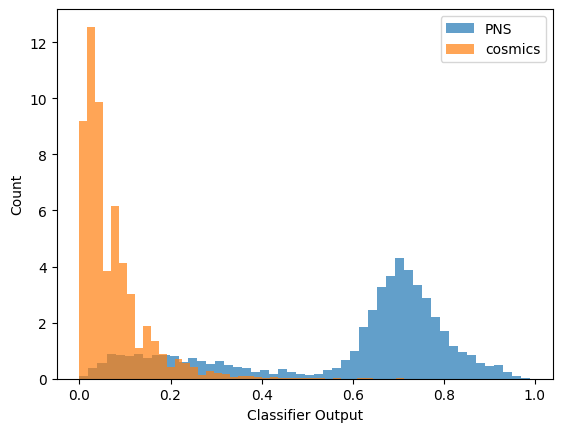

In [20]:
# Step 5: Visualize score distribution
plt.hist(cls_output_pns, bins=50, alpha=0.7, density=True, label='PNS')
plt.hist(cls_output_cr, bins=50, alpha=0.7, density=True, label='cosmics')
# plt.title("Score Distribution for Signal+Noise Samples")
plt.xlabel("Classifier Output")
plt.ylabel("Count")
plt.legend()
plt.show()

In [ ]:
# # Optional: Rank samples by score
# top_signal_indices = np.argsort(cls_output)[::-1]
# top_signals = X_pns[top_signal_indices[:100]]  # Top 100 most "signal-like" samples